In [1]:
!pip install opendatasets librosa numpy torch matplotlib

In [ ]:
import opendatasets as od
import os

# Download the dataset
dataset_url = 'https://www.kaggle.com/datasets/mathurinache/the-lj-speech-dataset'
data_dir = './LJSpeech-1.1'

if not os.path.exists(data_dir):
    od.download(dataset_url)


In [2]:
import librosa
import numpy as np
import torch

# Path to the downloaded audio files
audio_files_path = os.path.join(data_dir, 'LJSpeech-1.1/wavs')
audio_files = [os.path.join(audio_files_path, f) for f in os.listdir(audio_files_path) if f.endswith('.wav')]

def process_audio(file_path):
    y, sr = librosa.load(file_path, sr=22050)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db

mel_specs = [process_audio(file) for file in audio_files[:100]]  # Limit to 100 files for now


In [3]:
# Split the data: 60% for training and 40% for testing
split_idx = int(len(mel_specs) * 0.95)
train_mel_specs = mel_specs[:split_idx]
test_mel_specs = mel_specs[split_idx:]


In [4]:
def create_batches(data, batch_size=2, block_size=128):
    data_batches = []
    for i in range(0, len(data), batch_size):
        batch = data[i:i+batch_size]
        if len(batch) == batch_size:
            data_batches.append(batch)
    return data_batches

train_batches = create_batches(train_mel_specs)
test_batches = create_batches(test_mel_specs)


In [5]:
def prepare_data(batches, block_size=128):
    inputs, targets = [], []
    for batch in batches:
        for mel_spec in batch:
            mel_spec = (mel_spec - np.mean(mel_spec)) / np.std(mel_spec)  # Normalize
            for i in range(0, mel_spec.shape[1] - block_size, block_size):
                input_seq = mel_spec[:, i:i+block_size]
                target_seq = mel_spec[:, i+1:i+block_size+1]
                inputs.append(input_seq)
                targets.append(target_seq)
                
    inputs = np.array(inputs)
    targets = np.array(targets)
    
    inputs_tensor = torch.tensor(inputs, dtype=torch.float32)
    targets_tensor = torch.tensor(targets, dtype=torch.float32)
    
    return inputs_tensor, targets_tensor

train_inputs, train_targets = prepare_data(train_batches)
test_inputs, test_targets = prepare_data(test_batches)


In [6]:
import torch.nn as nn

class ImprovedRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=3):
        super(ImprovedRNN, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.3)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device)
        c0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out)
        return out

input_size = 128
hidden_size = 256  # Increased hidden size
output_size = 128
num_layers = 3  # Added more layers

model = ImprovedRNN(input_size, hidden_size, output_size, num_layers)


In [7]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

epochs = 30
batch_size = 16
patience = 5  # Early stopping patience

def train_model(model, train_inputs, train_targets, test_inputs, test_targets, batch_size, epochs, patience):
    model.train()
    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        permutation = torch.randperm(train_inputs.size(0))
        epoch_loss = 0

        for i in range(0, train_inputs.size(0), batch_size):
            indices = permutation[i:i + batch_size]
            batch_inputs, batch_targets = train_inputs[indices], train_targets[indices]

            optimizer.zero_grad()
            output = model(batch_inputs)
            loss = criterion(output, batch_targets)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_epoch_loss = epoch_loss / (train_inputs.size(0) // batch_size)
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {avg_epoch_loss:.4f}')

        # Validation step
        model.eval()
        with torch.no_grad():
            val_output = model(test_inputs)
            val_loss = criterion(val_output, test_targets).item()
            print(f'Validation Loss: {val_loss:.4f}')
            scheduler.step(val_loss)

        # Early stopping
        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping")
                break

        model.train()

train_model(model, train_inputs, train_targets, test_inputs, test_targets, batch_size, epochs, patience)


Epoch [1/30], Loss: 0.9070
Validation Loss: 0.7514
Epoch [2/30], Loss: 0.7305
Validation Loss: 0.6228
Epoch [3/30], Loss: 0.6144
Validation Loss: 0.5279
Epoch [4/30], Loss: 0.5279
Validation Loss: 0.4585
Epoch [5/30], Loss: 0.4621
Validation Loss: 0.4181
Epoch [6/30], Loss: 0.4093
Validation Loss: 0.3731
Epoch [7/30], Loss: 0.3675
Validation Loss: 0.3431
Epoch [8/30], Loss: 0.3318
Validation Loss: 0.3073
Epoch [9/30], Loss: 0.3017
Validation Loss: 0.2815
Epoch [10/30], Loss: 0.2741
Validation Loss: 0.2570
Epoch [11/30], Loss: 0.2497
Validation Loss: 0.2324
Epoch [12/30], Loss: 0.2296
Validation Loss: 0.2175
Epoch [13/30], Loss: 0.2130
Validation Loss: 0.2023
Epoch [14/30], Loss: 0.2002
Validation Loss: 0.1910
Epoch [15/30], Loss: 0.1885
Validation Loss: 0.1819
Epoch [16/30], Loss: 0.1782
Validation Loss: 0.1718
Epoch [17/30], Loss: 0.1690
Validation Loss: 0.1614
Epoch [18/30], Loss: 0.1613
Validation Loss: 0.1539
Epoch [19/30], Loss: 0.1542
Validation Loss: 0.1465
Epoch [20/30], Loss: 

In [8]:
def MAPE(actual, prediction):
    """
    Calculate the Mean Absolute Percentage Error (MAPE) between two lists.
    
    MAPE is a measure of prediction accuracy of a forecasting method in statistics,
    specifically trending markets. It expresses accuracy as a percentage, and is defined
    by the formula: MAPE = (1/n) * Σ(|actual - prediction| / |actual|) * 100
    
    Parameters:
    - actual (list or array-like): The actual data points. Must be 1-dimensional and 
      the same length as 'prediction'.
    - prediction (list or array-like): The predicted data points, which correspond to 
      'actual'. Must be 1-dimensional and the same length as 'actual'.

    Returns:
    - float: The mean absolute percentage error (MAPE) as a percentage, rounded to two decimal places.
    """
    actual, prediction = np.array(actual), np.array(prediction)
    if np.any(actual == 0):
        raise ValueError("MAPE is undefined for zero actual values because of division by zero")
    mape = np.mean(np.abs((actual - prediction) / actual)) * 100
    return round(mape, 2)

In [9]:
model.eval()  # Set the model to evaluation mode

with torch.no_grad():  # Disable gradient calculation for evaluation
    test_outputs = model(test_inputs)
    mse = criterion(test_outputs, test_targets).item()
    print(f'Mean Squared Error on test data: {mse:.4f}')


Mean Squared Error on test data: 0.1037


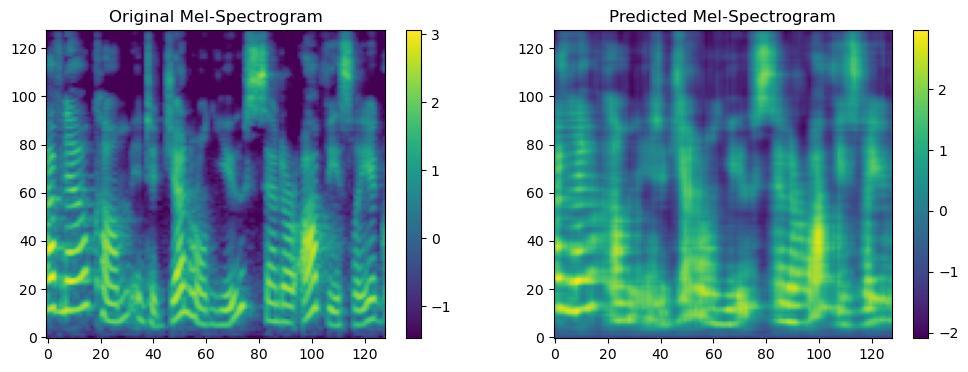

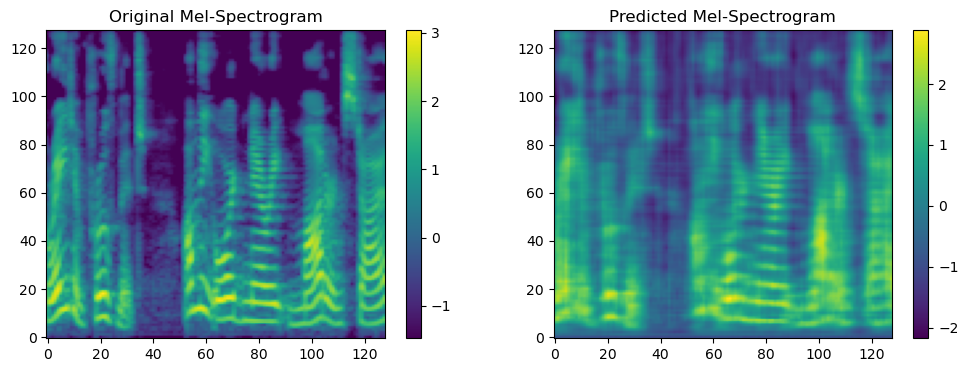

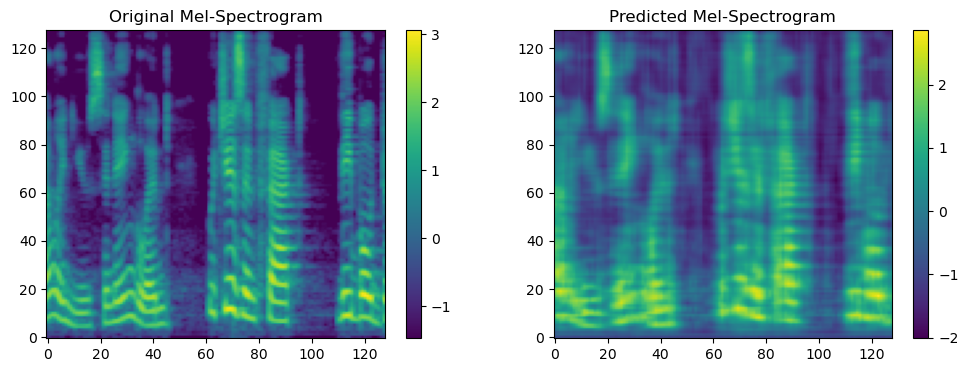

In [10]:
import matplotlib.pyplot as plt

num_examples = 3
for i in range(num_examples):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.title('Original Mel-Spectrogram')
    plt.imshow(test_targets[i].cpu().numpy(), aspect='auto', origin='lower')
    plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.title('Predicted Mel-Spectrogram')
    plt.imshow(test_outputs[i].cpu().numpy(), aspect='auto', origin='lower')
    plt.colorbar()

    plt.show()
